# Лабораторная работа №3: Исследование решающих деревьев

## Часть 1: Дерево решений для классификации (сухие бобы)

### Описание задачи
Использование дерева решений для классификации видов сухих бобов. Решающее дерево строит
иерархическую структуру условий на основе признаков для классификации объектов.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Загрузка и подготовка данных

In [3]:
df_beans = pd.read_csv('/content/drive/MyDrive/datasets/Dry_Bean_Dataset.csv')

X_beans = df_beans.drop('Class', axis=1)
y_beans = df_beans['Class']

X_train_beans, X_test_beans, y_train_beans, y_test_beans = train_test_split(
    X_beans, y_beans, test_size=0.2, random_state=42, stratify=y_beans
)

print(f'Обучающая выборка: {X_train_beans.shape}')
print(f'Тестовая выборка: {X_test_beans.shape}')

Обучающая выборка: (10888, 16)
Тестовая выборка: (2723, 16)


Важно: решающие деревья не требуют стандартизации признаков, так как они используют пороги для разбиения данных.

## 2. Бейзлайн: базовое дерево решений

In [4]:
tree_baseline = DecisionTreeClassifier(random_state=42)
tree_baseline.fit(X_train_beans, y_train_beans)

y_pred_baseline = tree_baseline.predict(X_test_beans)
acc_baseline = accuracy_score(y_test_beans, y_pred_baseline)

print(f'Baseline Accuracy: {acc_baseline:.4f}')
print(f'Глубина дерева: {tree_baseline.get_depth()}')
print(f'Количество листьев: {tree_baseline.get_n_leaves()}')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_baseline))

Baseline Accuracy: 0.8920
Глубина дерева: 29
Количество листьев: 692

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.88      0.91      0.89       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.91      0.92       326
    DERMASON       0.88      0.90      0.89       709
       HOROZ       0.94      0.91      0.93       386
       SEKER       0.91      0.95      0.93       406
        SIRA       0.83      0.79      0.81       527

    accuracy                           0.89      2723
   macro avg       0.91      0.91      0.91      2723
weighted avg       0.89      0.89      0.89      2723



## 3. Улучшение бейзлайна

### Гипотеза 1: Ограничение глубины дерева

Глубокие деревья часто переобучаются. Найдём оптимальную глубину через кросс-валидацию.

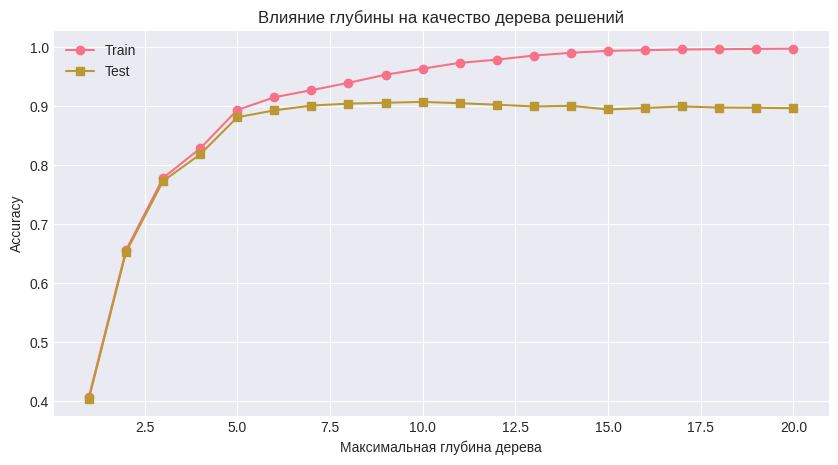

Оптимальная глубина: 10


In [5]:
max_depths = range(1, 21)
train_scores = []
test_scores = []

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train_beans, y_train_beans)
    train_scores.append(tree.score(X_train_beans, y_train_beans))
    test_scores.append(tree.score(X_test_beans, y_test_beans))

plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_scores, marker='o', label='Train')
plt.plot(max_depths, test_scores, marker='s', label='Test')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Accuracy')
plt.title('Влияние глубины на качество дерева решений')
plt.legend()
plt.grid(True)
plt.show()

best_depth = max_depths[np.argmax(test_scores)]
print(f'Оптимальная глубина: {best_depth}')

### Гипотеза 2: Минимальное число образцов в листе

Увеличение min_samples_leaf помогает избежать переобучения на шумовых примерах.

In [6]:
min_samples = [1, 2, 5, 10, 15, 20]
leaf_scores = []

for min_leaf in min_samples:
    tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=min_leaf, random_state=42)
    tree.fit(X_train_beans, y_train_beans)
    score = tree.score(X_test_beans, y_test_beans)
    leaf_scores.append(score)
    print(f'min_samples_leaf={min_leaf}: {score:.4f}')

best_min_leaf = min_samples[np.argmax(leaf_scores)]
print(f'\nОптимальный min_samples_leaf: {best_min_leaf}')

min_samples_leaf=1: 0.9071
min_samples_leaf=2: 0.9071
min_samples_leaf=5: 0.9075
min_samples_leaf=10: 0.9097
min_samples_leaf=15: 0.9045
min_samples_leaf=20: 0.9056

Оптимальный min_samples_leaf: 10


### Улучшенное дерево решений

In [7]:
tree_improved = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_leaf=best_min_leaf,
    random_state=42
)
tree_improved.fit(X_train_beans, y_train_beans)

y_pred_improved = tree_improved.predict(X_test_beans)
acc_improved = accuracy_score(y_test_beans, y_pred_improved)

print(f'Улучшенная модель Accuracy: {acc_improved:.4f}')
print(f'Улучшение: {(acc_improved - acc_baseline) * 100:.2f}%')
print(f'Глубина дерева: {tree_improved.get_depth()}')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_improved))

Улучшенная модель Accuracy: 0.9097
Улучшение: 1.76%
Глубина дерева: 10

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.89      0.91       265
      BOMBAY       1.00      0.99      1.00       104
        CALI       0.93      0.93      0.93       326
    DERMASON       0.89      0.93      0.91       709
       HOROZ       0.96      0.93      0.95       386
       SEKER       0.93      0.95      0.94       406
        SIRA       0.85      0.83      0.84       527

    accuracy                           0.91      2723
   macro avg       0.93      0.92      0.92      2723
weighted avg       0.91      0.91      0.91      2723



### Важность признаков

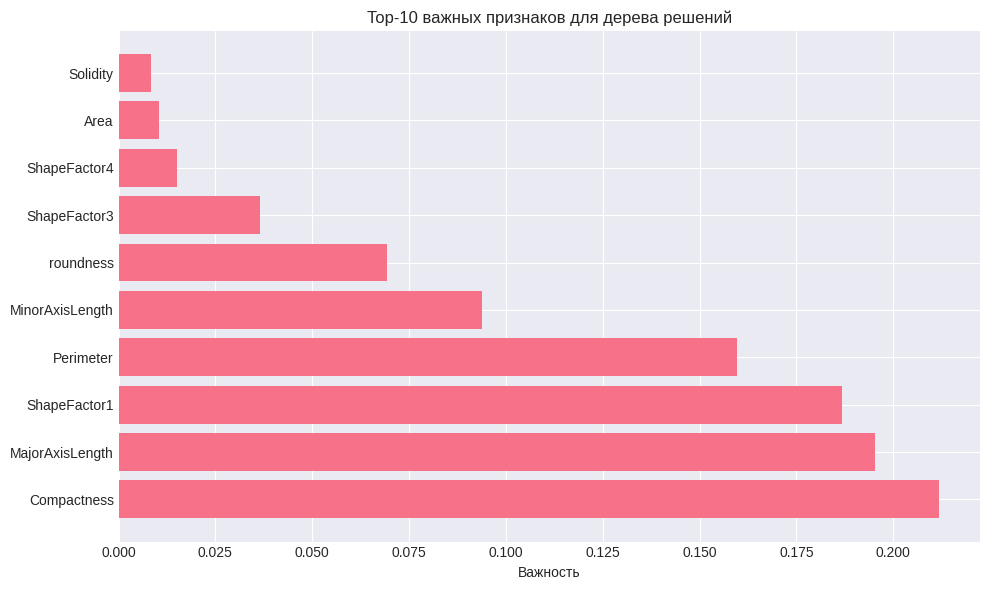


Топ-5 признаков:
            Feature  Importance
11      Compactness    0.211827
2   MajorAxisLength    0.195391
12     ShapeFactor1    0.186907
1         Perimeter    0.159785
3   MinorAxisLength    0.093864


In [8]:
feature_importance = pd.DataFrame({
    'Feature': X_beans.columns,
    'Importance': tree_improved.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Важность')
plt.title('Top-10 важных признаков для дерева решений')
plt.tight_layout()
plt.show()

print('\nТоп-5 признаков:')
print(feature_importance.head())

## 4. Собственная реализация дерева решений

Реализация простого дерева решений с использованием критерия Gini для разбиения узлов.

In [15]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CustomDecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.classes_ = None

    def _gini(self, y):
        counter = pd.Series(y).value_counts()
        probabilities = counter / len(y)
        impurity = 1.0 - sum(p ** 2 for p in probabilities)
        return impurity

    def _split(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < 2 * self.min_samples_leaf or \
           n_classes == 1:
            leaf_value = pd.Series(y).value_counts().idxmax()
            return Node(value=leaf_value)

        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])

            if len(unique_values) > 10:
                thresholds = np.percentile(unique_values, np.linspace(10, 90, 9))
            else:
                thresholds = unique_values[:-1]

            for threshold in thresholds:
                X_l, X_r, y_l, y_r = self._split(X, y, feature, threshold)

                if len(y_l) < self.min_samples_leaf or len(y_r) < self.min_samples_leaf:
                    continue

                gini_left = self._gini(y_l) * len(y_l)
                gini_right = self._gini(y_r) * len(y_r)
                gini = (gini_left + gini_right) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        if best_feature is None:
            leaf_value = pd.Series(y).value_counts().idxmax()
            return Node(value=leaf_value)

        X_l, X_r, y_l, y_r = self._split(X, y, best_feature, best_threshold)
        left_subtree = self._build_tree(X_l, y_l, depth + 1)
        right_subtree = self._build_tree(X_r, y_r, depth + 1)

        return Node(feature=best_feature, threshold=best_threshold,
                    left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.tree = self._build_tree(X.values, y)
        return self

    def predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_sample(x, node.left)
        else:
            return self.predict_sample(x, node.right)

    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X.values])

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)


In [16]:
tree_custom = CustomDecisionTree(max_depth=best_depth, min_samples_leaf=best_min_leaf)
tree_custom.fit(X_train_beans, y_train_beans)

y_pred_custom = tree_custom.predict(X_test_beans)
acc_custom = accuracy_score(y_test_beans, y_pred_custom)

print(f'Собственная реализация Accuracy: {acc_custom:.4f}')
print(f'sklearn Accuracy: {acc_improved:.4f}')
print(f'Разница: {abs(acc_custom - acc_improved):.6f}')

Собственная реализация Accuracy: 0.9030
sklearn Accuracy: 0.9097
Разница: 0.006610


### Матрица ошибок

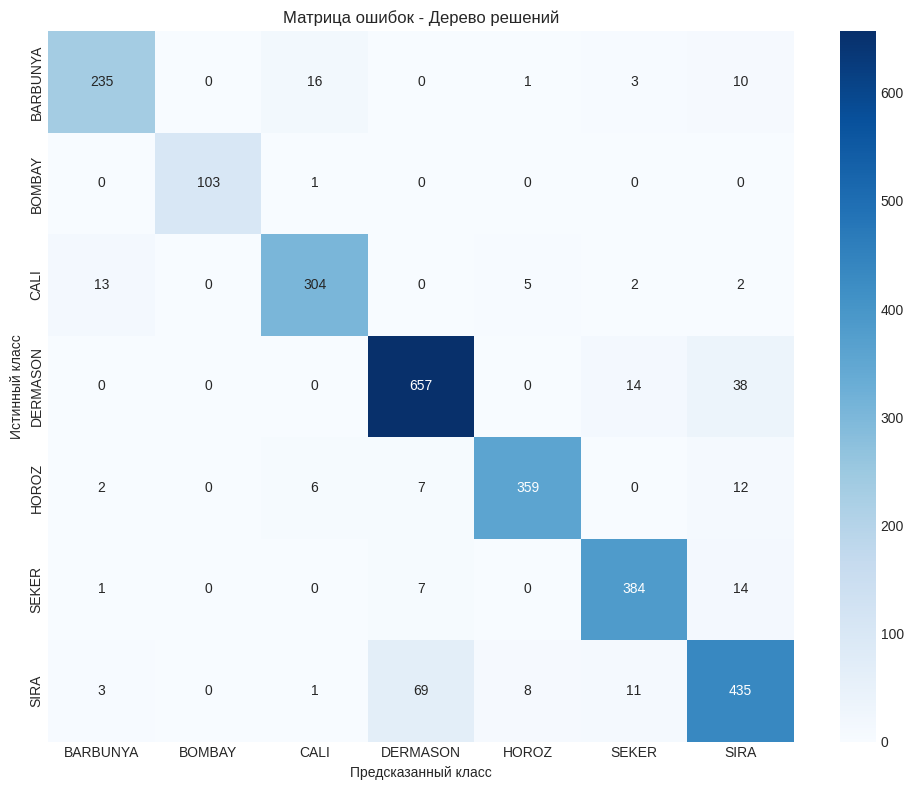

In [17]:
cm = confusion_matrix(y_test_beans, y_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tree_improved.classes_,
            yticklabels=tree_improved.classes_)
plt.title('Матрица ошибок - Дерево решений')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

### Сравнение результатов классификации


Сравнение моделей классификации:
                    Модель  Accuracy
Baseline (без ограничений)  0.892031
     Улучшенная (depth=10)  0.909658
    Собственная реализация  0.903048


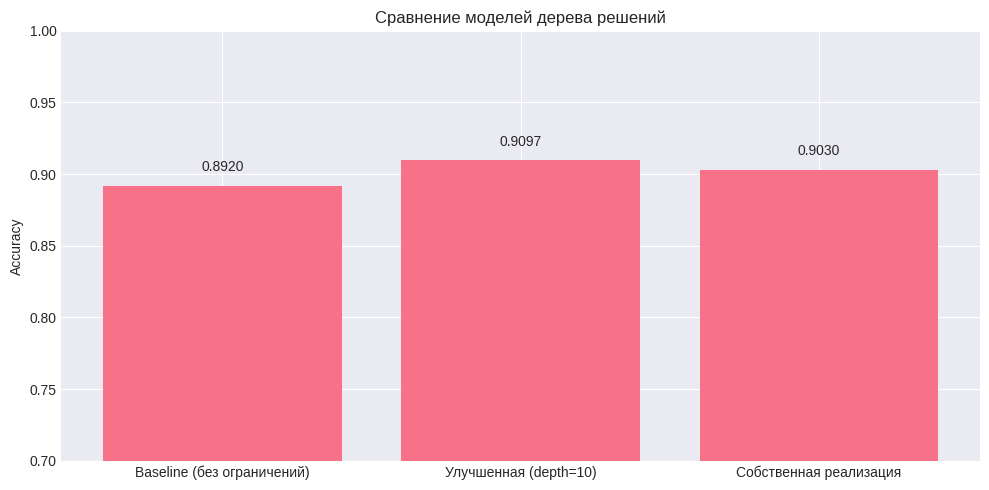

In [18]:
comparison_class = pd.DataFrame({
    'Модель': ['Baseline (без ограничений)', f'Улучшенная (depth={best_depth})', 'Собственная реализация'],
    'Accuracy': [acc_baseline, acc_improved, acc_custom]
})
print('\nСравнение моделей классификации:')
print(comparison_class.to_string(index=False))

plt.figure(figsize=(10, 5))
plt.bar(comparison_class['Модель'], comparison_class['Accuracy'])
plt.ylabel('Accuracy')
plt.title('Сравнение моделей дерева решений')
plt.ylim([0.7, 1.0])
for i, v in enumerate(comparison_class['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

### Выводы по классификации с деревом решений

1. Деревья решений отличной интерпретируемостью и не требуют нормализации.
2. Ограничение глубины критично для предотвращения переобучения.
3. Параметр min_samples_leaf помогает сделать модель более устойчивой к шуму.
4. Важность признаков дает понимание о том, какие признаки наиболее информативны.

---

## Часть 2: Дерево решений для регрессии (предсказание рейтинга вин)

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_wines = pd.read_csv('/content/drive/MyDrive/datasets/winemag-data-130k-v2.csv')


df_wines_sample = df_wines[['price', 'points']].sample(20000, random_state=42)
df_wines_clean = df_wines_sample.dropna()

X_wines = df_wines_clean.drop('points', axis=1)
y_wines = df_wines_clean['points']

X_train_wines, X_test_wines, y_train_wines, y_test_wines = train_test_split(
    X_wines, y_wines, test_size=0.2, random_state=42
)

print(f'Обучающая выборка: {X_train_wines.shape}')
print(f'Тестовая выборка: {X_test_wines.shape}')

Обучающая выборка: (14883, 1)
Тестовая выборка: (3721, 1)


## 2. Бейзлайн: базовое регрессионное дерево

In [20]:
tree_reg_baseline = DecisionTreeRegressor(random_state=42)
tree_reg_baseline.fit(X_train_wines, y_train_wines)

y_pred_reg_baseline = tree_reg_baseline.predict(X_test_wines)

mae_baseline = mean_absolute_error(y_test_wines, y_pred_reg_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_baseline))
r2_baseline = r2_score(y_test_wines, y_pred_reg_baseline)

print('Baseline дерево регрессии:')
print(f'MAE: {mae_baseline:.4f}')
print(f'RMSE: {rmse_baseline:.4f}')
print(f'R²: {r2_baseline:.4f}')
print(f'Глубина дерева: {tree_reg_baseline.get_depth()}')
print(f'Количество листьев: {tree_reg_baseline.get_n_leaves()}')

Baseline дерево регрессии:
MAE: 1.8805
RMSE: 2.4011
R²: 0.3880
Глубина дерева: 19
Количество листьев: 207


## 3. Улучшение бейзлайна

### Подбор глубины и min_samples_leaf

Оптимальная глубина: 5 с R²: 0.3963


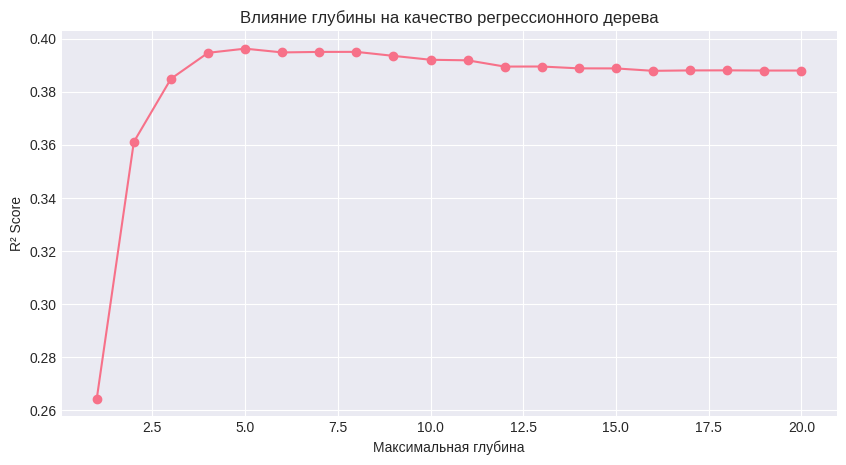

In [21]:
max_depths_reg = range(1, 21)
r2_scores_reg = []

for depth in max_depths_reg:
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X_train_wines, y_train_wines)
    r2 = tree_reg.score(X_test_wines, y_test_wines)
    r2_scores_reg.append(r2)

best_depth_reg = max_depths_reg[np.argmax(r2_scores_reg)]
print(f'Оптимальная глубина: {best_depth_reg} с R²: {max(r2_scores_reg):.4f}')

plt.figure(figsize=(10, 5))
plt.plot(max_depths_reg, r2_scores_reg, marker='o')
plt.xlabel('Максимальная глубина')
plt.ylabel('R² Score')
plt.title('Влияние глубины на качество регрессионного дерева')
plt.grid(True)
plt.show()

### Улучшенное дерево регрессии

In [22]:
tree_reg_improved = DecisionTreeRegressor(max_depth=best_depth_reg, min_samples_leaf=5, random_state=42)
tree_reg_improved.fit(X_train_wines, y_train_wines)

y_pred_reg_improved = tree_reg_improved.predict(X_test_wines)

mae_improved = mean_absolute_error(y_test_wines, y_pred_reg_improved)
rmse_improved = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_improved))
r2_improved = r2_score(y_test_wines, y_pred_reg_improved)

print('Улучшенное дерево регрессии:')
print(f'MAE: {mae_improved:.4f}')
print(f'RMSE: {rmse_improved:.4f}')
print(f'R²: {r2_improved:.4f}')
print(f'Улучшение R²: {(r2_improved - r2_baseline) * 100:.2f}%')

Улучшенное дерево регрессии:
MAE: 1.8708
RMSE: 2.3848
R²: 0.3963
Улучшение R²: 0.83%


### Собственная реализация регрессионного дерева

In [23]:
class NodeReg:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _split(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]

        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < 2 * self.min_samples_leaf:
            return NodeReg(value=np.mean(y))

        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            unique_values = np.unique(X[:, feature])
            if len(unique_values) > 10:
                thresholds = np.percentile(unique_values, np.linspace(10, 90, 9))
            else:
                thresholds = unique_values[:-1]

            for threshold in thresholds:
                X_l, X_r, y_l, y_r = self._split(X, y, feature, threshold)
                if len(y_l) < self.min_samples_leaf or len(y_r) < self.min_samples_leaf:
                    continue

                mse = (len(y_l) * self._mse(y_l) + len(y_r) * self._mse(y_r)) / n_samples
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        if best_feature is None:
            return NodeReg(value=np.mean(y))

        X_l, X_r, y_l, y_r = self._split(X, y, best_feature, best_threshold)
        left_subtree = self._build_tree(X_l, y_l, depth + 1)
        right_subtree = self._build_tree(X_r, y_r, depth + 1)

        return NodeReg(feature=best_feature, threshold=best_threshold,
                       left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        self.tree = self._build_tree(X_array, y_array)
        return self

    def predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_sample(x, node.left)
        else:
            return self.predict_sample(x, node.right)

    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        return np.array([self.predict_sample(x, self.tree) for x in X_array])

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return r2_score(y_array, predictions)


In [24]:
tree_reg_custom = CustomDecisionTreeRegressor(max_depth=best_depth_reg, min_samples_leaf=5)
tree_reg_custom.fit(X_train_wines, y_train_wines)

y_pred_reg_custom = tree_reg_custom.predict(X_test_wines)

mae_custom = mean_absolute_error(y_test_wines, y_pred_reg_custom)
rmse_custom = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_custom))
r2_custom = r2_score(y_test_wines, y_pred_reg_custom)

print('Собственная реализация:')
print(f'MAE: {mae_custom:.4f}')
print(f'RMSE: {rmse_custom:.4f}')
print(f'R²: {r2_custom:.4f}')

Собственная реализация:
MAE: 1.8732
RMSE: 2.3881
R²: 0.3947


### Визуализация результатов

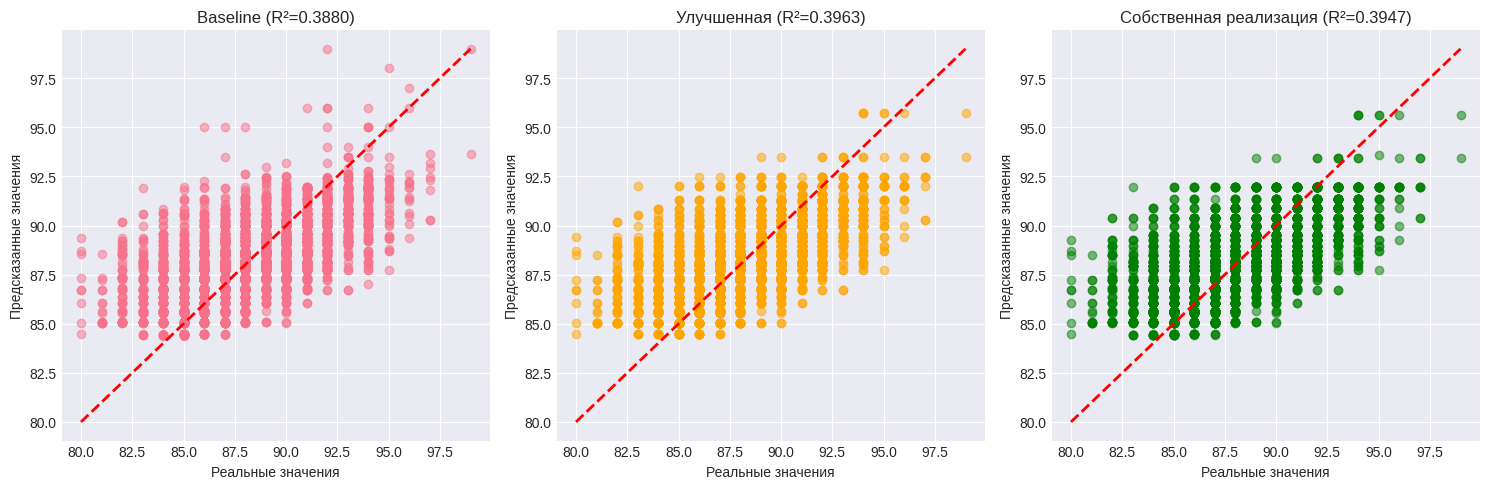

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_wines, y_pred_reg_baseline, alpha=0.5)
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Baseline (R²={r2_baseline:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test_wines, y_pred_reg_improved, alpha=0.5, color='orange')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Улучшенная (R²={r2_improved:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_test_wines, y_pred_reg_custom, alpha=0.5, color='green')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Собственная реализация (R²={r2_custom:.4f})')

plt.tight_layout()
plt.show()

### Сравнение результатов регрессии

In [26]:
comparison_reg = pd.DataFrame({
    'Модель': ['Baseline', f'Улучшенная (depth={best_depth_reg})', 'Собственная реализация'],
    'MAE': [mae_baseline, mae_improved, mae_custom],
    'RMSE': [rmse_baseline, rmse_improved, rmse_custom],
    'R²': [r2_baseline, r2_improved, r2_custom]
})
print('\nСравнение моделей регрессии:')
print(comparison_reg.to_string(index=False))


Сравнение моделей регрессии:
                Модель      MAE     RMSE       R²
              Baseline 1.880459 2.401063 0.388036
  Улучшенная (depth=5) 1.870839 2.384816 0.396290
Собственная реализация 1.873176 2.388053 0.394650


### Выводы по ЛР№3

1. **Деревья решений** - мощный инструмент как для классификации, так и для регрессии.
2. **Интерпретируемость** - главное преимущество перед другими методами; можно легко объяснить решение модели.
3. **Гиперпараметры** - ограничение глубины и min_samples_leaf критичны для предотвращения переобучения.
4. **Важность признаков** - помогает выявить наиболее значимые переменные для предсказаний.
5. **Пространственная сложность** - собственная реализация медленнее, но демонстрирует основные принципы построения дерева.